# How Convolution layer works?


- 기수: 14기

- 이름: 조재현

- 작성자: 13기 강승우

압축을 해제한 폴더 그대로 경로 변경 없이 문제를 푸시면됩니다.  
**CNN assignment폴더 아래에 data폴더, CNN 노트북파일, 이미지파일이 위치해야합니다.**  
문제가 생길 경우 경로 코드를 수정하시거나, 학술부에게 문의해주세요

이번 문제에서는 직접 Convolution 연산을 구현해보며 CNN의 동작 원리를 알아보고자 합니다.

**목표**
- `nn.Conv2d`와 동일한 연산을 **NumPy로 직접 구현**
- laplacian filter와 sobel filter를 **이미지에 적용**

**라이브러리 및 함수 정의**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Tuple, Optional

# 시각화 유틸
def show_gray(img, title=None):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def minmax_norm(x: np.ndarray, eps: float = 1e-12):
    mn, mx = np.min(x), np.max(x)
    if mx - mn < eps:
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)

**이미지 준비**

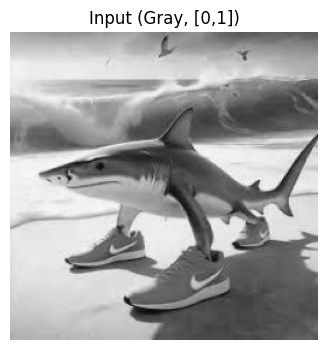

In [ ]:
def load_image(path: Optional[str] = None, size: Tuple[int,int]=(256,256)) -> np.ndarray:
    img = Image.open(path).convert('L').resize(size, Image.BILINEAR)
    arr = np.array(img, dtype=np.float32) / 255.0
    return arr

# 사용 예시: path=None -> 합성 이미지
img = load_image(path="/content/tralla.jpg", size=(256,256))
show_gray(img, title='Input (Gray, [0,1])')


**Q1. numpy를 사용하여 이미지와 커널 배열을 입력으로 받는 conv2D_naive 함수를 구현하세요**

In [ ]:
import numpy as np

def conv2d_naive(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    image: (H, W)
    kernel: (kH, kW)

    반환: (outH, outW)
    """
    # padding=0, stride=1 조건으로 구현
    padding = 0 # padding = 0은 이미지의 가장자리에 추가할 픽셀의 수를 0으로 설정
    padded = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')
    stride = 1 # 보폭

    ## Todo ##
    H, W = image.shape
    kH, kW = kernel.shape

    outH = (H - kH) // stride + 1 #이 공식은 높이 방향으로 몇 번의 합성곱 연산이 가능한지 계산
    #H - kH: 이미지를 위에서 아래로 스캔할 때, 커널이 움직일 수 있는 최대 거리를 의미. 커널의 크기(kH)만큼은 빼줘야 마지막 연산이 가능하기 때문

    outW = (W - kW) // stride + 1

    out = np.zeros((outH, outW)) # out = np.zeros((outH, outW))는 위에서 계산한 outH와 outW 크기에 맞춰 모든 값이 0으로 채워진 NumPy 배열을 생성
    # 왜 0으로 초기화할까요?
    #합성곱 연산의 결과는 최종적으로 이 배열에 차례대로 채워질 것입니다.
    # 이 배열을 미리 만들어두고, 계산된 값을 해당 위치에 하나씩 저장하는 방식으로 코드를 구현하는 것이 효율적

    for y in range(outH):
        for x in range(outW):
            # 이미지에서 커널 크기만큼의 영역을 잘라냅니다.
            # y와 x에 stride를 곱하여 픽셀 위치를 조정합니다.
            y_start = y * stride
            y_end = y_start + kH
            x_start = x * stride
            x_end = x_start + kW

            # "커널 크기만큼 잘라낸다"는 것은 커널이 이미지를 한 픽셀씩 훑으면서 자신이 덮는 영역을 마치 도려내듯 선택하여 연산에 사용

            # 잘라낸 부분 이미지(patch)와 커널을 원소별로 곱합니다.
            image_patch = padded[y_start:y_end, x_start:x_end]
            elementwise_product = image_patch * kernel

            # 곱한 결과를 모두 더해 최종 출력 픽셀 값을 계산합니다.
            out[y, x] = np.sum(elementwise_product)

    ##########
    return out

**Q2. 작성한 코드의 동작 방식이 왜 CNN의 convolution 연산과 동일한지 아래 마크다운에 자세히 설명해주세요. (예시를 들어 설명하셔도 좋습니다)**

conv2d_naive 함수는 CNN의 컨볼루션 연산과 정확히 동일한 방식으로 동작합니다. 이는 연산의 세 가지 핵심 요소인 슬라이딩 윈도우, 원소별 곱셈, 그리고 합산을 그대로 구현했기 때문입니다.

1. 슬라이딩 윈도우 (Sliding Window)
CNN 연산: 커널(필터)이 이미지의 왼쪽 상단부터 시작해 오른쪽으로, 그리고 아래로 한 칸씩 이동하며 이미지를 훑습니다.

코드의 동작:

for y in range(outH):와 for x in range(outW):는 출력 이미지의 모든 픽셀을 순회하는 이중 루프입니다.

y_start = y * stride, x_start = x * stride 코드는 현재 (y, x) 위치에 해당하는 원본 이미지의 시작점을 계산합니다. stride가 1이므로, (0,0)에서 (0,1)로, 다시 (0,2)로 한 칸씩 이동하는 슬라이딩 윈도우를 완벽하게 재현합니다.

2. 원소별 곱셈 (Element-wise Multiplication)
CNN 연산: 커널이 이미지의 특정 영역 위에 놓이면, 커널과 해당 이미지 영역의 원소들을 1:1로 짝지어 곱합니다.

코드의 동작:

image_patch = padded[y_start:y_end, x_start:x_end]는 루프가 현재 가리키는 이미지 영역을 정확히 잘라냅니다.

elementwise_product = image_patch * kernel는 NumPy의 원소별 곱셈 기능을 사용해, 잘라낸 부분 이미지와 커널을 위치별로 곱하는 CNN 연산을 그대로 수행합니다.

3. 합산 (Summation)
CNN 연산: 원소별 곱셈의 결과들을 모두 더해 하나의 최종 값으로 만듭니다.

코드의 동작:

np.sum(elementwise_product)는 원소별 곱셈의 결과 배열에 있는 모든 값을 더합니다.

out[y, x] = np.sum(...)는 이 합산 값을 출력 이미지의 (y, x) 위치에 저장합니다.

**라플라시안 필터 적용 및 시각화**


- Laplace Filter  
\begin{bmatrix}
1 & 1 & 1\\
1 & -8 & 1\\
1 & 1 & 1
\end{bmatrix}

- Sobel Filter(수직)  
\begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}

- Sobel Filter(수평)
\begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
1 & 2 & 1
\end{bmatrix}


In [ ]:
laplace = np.array([[ 1, 1, 1],
                    [ 1,-8, 1],
                    [ 1, 1, 1]], dtype=np.float32)

sobel_vertical = np.array([[ -1, 0, 1],
                           [ -2, 0, 2],
                           [ -1, 0, 1]], dtype=np.float32)

sobel_horizontal = np.array([[ -1, -2, -1],
                             [  0,  0,  0],
                             [  1,  2,  2]], dtype=np.float32)

print('laplace:\n', laplace)
print('sobel_vertical\n', sobel_vertical)
print('sobel_horizontal:\n', sobel_horizontal)

laplace:
 [[ 1.  1.  1.]
 [ 1. -8.  1.]
 [ 1.  1.  1.]]
sobel_vertical
 [[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]
sobel_horizontal:
 [[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  2.]]


**구현한 Conv함수와 주어진 filter로 이미지의 edge를 검출해보세요**
- 결과의 범위가 음수가 될 수 있어, 시각화를 위해 정규화 사용

In [ ]:
def apply_filter_and_visualize(img: np.ndarray, kernel: np.ndarray, stride: int = 1):

    resp = conv2d_naive(img, kernel)
    resp_signed = minmax_norm(resp)      # [-?, +?] -> [0,1] 정규화

    show_gray(img, 'Input')
    show_gray(resp_signed, 'Laplacian response (signed → min-max normalized)')
    return resp

=== Laplacian ===


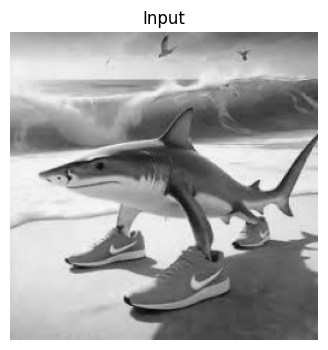

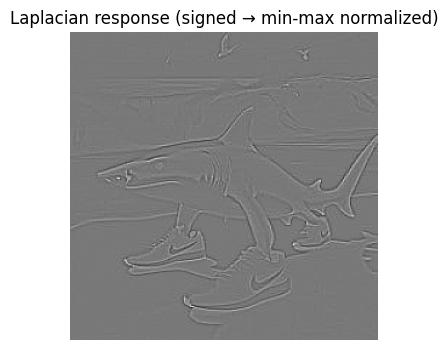

=== Sobel Vertical ===


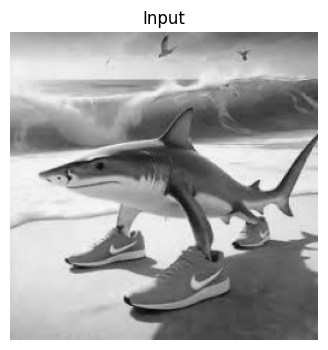

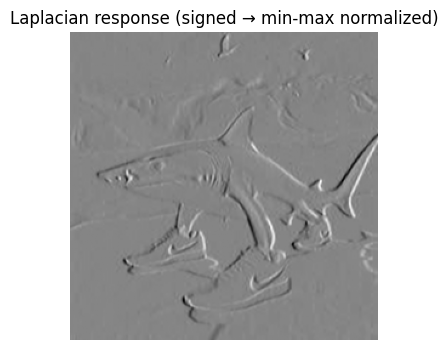

=== Sobel Horizontal ===


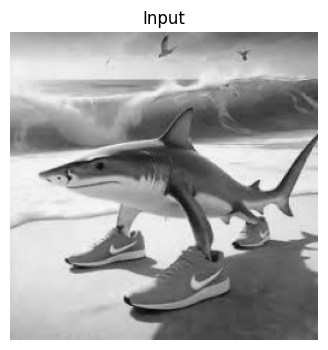

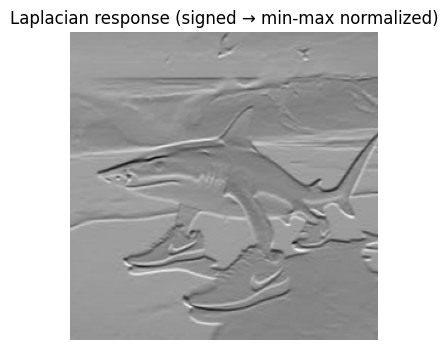

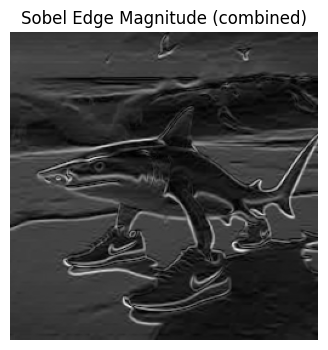

In [ ]:
print('=== Laplacian ===')
resp_lp = apply_filter_and_visualize(img, laplace)

print('=== Sobel Vertical ===')
resp_sv = apply_filter_and_visualize(img, sobel_vertical)

print('=== Sobel Horizontal ===')
resp_sh = apply_filter_and_visualize(img, sobel_horizontal)

edge_mag = np.sqrt(resp_sv**2 + resp_sh**2)
edge_mag = minmax_norm(edge_mag)

show_gray(edge_mag, 'Sobel Edge Magnitude (combined)')

# Resnet18 구현하기

앞선 문제에서 Convolution 연산을 구현하여 보았으니,  
이번에는 **Resnet18을 직접 구현**해보고자 합니다.  
**Pytorch의 nn.Conv2d를 사용하시면 되지만**,  
본인이 구현한 Conv2d가 backward 연산이 가능하도록 설계되었다면 그것을 사용하여 구현하셔도 좋습니다.

**라이브러리 및 함수 정의**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

data_path = "./data"

batch_size = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:02<00:00, 75.3MB/s]


In [ ]:
def train(model, trainloader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.01,
        weight_decay=5e-4,
        momentum=0.9
    )
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(trainloader,desc=f'Epoch {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainloader)}")

def test(model, testloader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

**Q1. CIFAR10 데이터셋을 분류하는 Resnet18 classifier를 구현하세요**

Input (Batch size x 3 x 32 x 32) / Output (Batch size x Num class)  
이미지 배치를 입력받아 label 개수에 맞는 logit을 반환하도록 BasicBlock과 ResNet18 class를 정의해주세요.  
**ImageNet(224x224)을 입력으로 받는 Original ResNet18과 달리 CIFAR10(32x32)을 입력으로 받으므로,**  
- **conv1과 conv2 layer의 filter size와, maxpooling, stride,**  
- **fc layer의 output dimension을 적절히 변형하셔야 합니다.**
- **ResNet의 Architecture는 아래와 같습니다**

![사진](./ResNet_Architectures.png)

In [3]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    """
    ResNet의 기본 블록을 정의합니다. # ResNet의 기본 블록은 정보 손실 없이 깊은 신경망을 만들기 위해 필요합니다.
    # 신경망의 층을 깊게 쌓을수록 성능이 좋아질 것 같지만, 실제로는 층이 깊어질수록 기울기 소실(vanishing gradient) 문제가 발생해 학습이 제대로 되지 않아요. 기울기(gradient)는 모델이 학습할 때 중요한 정보인데, 층을 통과할 때마다 이 정보가 점점 희미해져서 결국엔 아무것도 학습하지 못하게 되는 것이죠.
    # ResNet의 기본 블록은 이 문제를 해결하기 위해 **지름길(shortcut)**을 추가합니다.
    # 이 지름길 덕분에 기울기 정보가 사라지지 않고 블록을 통과할 수 있습니다.
    # 예를 들어, 블록이 아무것도 학습하지 않더라도, 지름길을 통해 입력이 그대로 다음 층으로 전달되므로 정보 손실이 발생하지 않습니다."""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1) -> None:
        super(BasicBlock, self).__init__()

        # ResNet의 Identity shortcut
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels) # 기본 블록으로 들어오는 입력 채널의 수(in_channels)가 블록에서 나가는 출력 채널의 수와 다른지 확인하는 조건
            )

        # 첫 번째 Conv-BatchNorm-ReLU 블록
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # 두 번째 Conv-BatchNorm 블록
        self.conv2 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.expansion * out_channels)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Identity shortcut connection # out 데이터에 원본 입력 데이터 x를 지름길로 보낸 값을 더해줍니다.
        out = self.relu(out)
        return out


class ResNet18(nn.Module):
    """
    CIFAR10 데이터셋을 위한 ResNet18 모델을 정의합니다.
    """
    def __init__(self, num_classes=10) -> None:
        super(ResNet18, self).__init__()

        self.in_channels = 64

        # CIFAR10에 맞게 수정된 첫 번째 Conv 층
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # CIFAR10은 32x32 크기이므로, MaxPool 층을 제거하거나 stride를 수정합니다.
        # 여기서는 MaxPool을 제거하고 stride를 1로 유지합니다.

        # ResNet18 레이어 스택
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # FC 층은 `512 * BasicBlock.expansion` 채널을 입력으로 받습니다.
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)  # Flatten
        out = self.fc(out)
        return out

모델이 안정적으로 학습되는지, 테스트 정확도가 잘 나오는지 (80% 이상) 확인해보세요

In [4]:
torch.manual_seed(42)
model = ResNet18().to(device)
train(model, trainloader, epochs=20)

NameError: name 'device' is not defined

In [1]:
test(model, testloader, device)

NameError: name 'test' is not defined

**Q2. Original ResNet18과 CIFAR10 분류용으로 구현한 ResNet18의 차이점과 그렇게 수정한 이유를 아래 마크다운에 자세히 설명해주세요.**

Original ResNet18과 CIFAR10용 ResNet18의 가장 큰 차이점은 입력 이미지의 크기에 맞춰 모델의 첫 번째 층을 변형했다는 점입니다. 원본 ResNet18은 ImageNet 데이터셋(224x224)을 위해 설계되었고, CIFAR10용은 더 작은 CIFAR10(32x32) 이미지를 처리할수 있도록 했습니다


* 첫 번째 합성곱 층 (conv1)의 수정
원본 ResNet18은 ImageNet의 큰 이미지(224x224)를 처리하기 위해 conv1 층에 kernel_size=7과 stride=2를 사용합니다. 이는 이미지의 너비와 높이를 절반으로 빠르게 줄여 연산량을 감소시킵니다. 하지만 CIFAR10 이미지는 이미 매우 작기 때문에(32x32), 동일하게 stride=2를 적용하면 이미지 크기가 16x16으로 줄어들어 필요한 특징 정보가 너무 많이 손실됩니다. 따라서 CIFAR10용 ResNet18은 **kernel_size=3과 stride=1**로 변경하여 이미지의 원래 크기를 보존하도록 설계했습니다.

* 최대 풀링 층 (Max pooling)의 제거
원본 ResNet18은 conv1 층 이후에 3x3 최대 풀링 층을 stride=2로 사용하여 이미지를 한 번 더 압축합니다. 이는 모델의 매개변수 수를 줄이고 주요 특징을 압축하는 데 효과적입니다. 그러나 CIFAR10 이미지의 경우 이 층을 적용하면 이미지가 지나치게 작아져(16x16 -> 8x8) 학습에 필요한 정보가 부족해집니다. 따라서 CIFAR10용 ResNet18에서는 최대 풀링 층을 제거하고, 대신 중간 layer에서 stride=2를 사용하여 점진적으로 이미지 크기를 줄이도록 수정했습니다.

결론적으로, CIFAR10용 ResNet18은 작은 입력 이미지에 맞춰 모델의 초기 구조를 변경함으로써 불필요한 정보 손실을 막고, 모델이 데이터로부터 효과적으로 학습할 수 있도록 최적화된 것입니다.